### Model-1

deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

### Model-2

This model Is using top words with moderate idf scores as words with extreme idf scores don't give much information and thus reduce vector dimensions

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png

## Note have attached reference links to get best DL model and code snippets

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [0]:

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Input,LSTM,Flatten,Embedding


Using TensorFlow backend.


In [0]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')
# get resource file from Drive

print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
  
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [0]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [0]:

   # merge two column text dataframe: 
    project_data["essay"] = project_data["project_essay_1"].map(str) +\
                            project_data["project_essay_2"].map(str) + \
                            project_data["project_essay_3"].map(str) + \
                            project_data["project_essay_4"].map(str) + \
                            project_data["project_title"]
    catogories = list(project_data['project_subject_categories'].values)
    # remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

    # https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
    # https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
    # https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
    cat_list = []
    for i in catogories:
        temp = ""
        # consider we have text like this "Math & Science, Warmth, Care & Hunger"
        for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
            if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
                j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
            j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
            temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
            temp = temp.replace('&','_') # we are replacing the & value into 
        cat_list.append(temp.strip())

    project_data['clean_categories'] = cat_list
    from collections import Counter
    my_counter = Counter()
    for word in project_data['clean_categories'].values:
        my_counter.update(word.split())

    cat_dict = dict(my_counter)


    #  preprocessing of project_subject_subcategories
    sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))
    sub_catogories = list(project_data['project_subject_subcategories'].values)
    # remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

    # https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
    # https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
    # https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

    sub_cat_list = []
    for i in sub_catogories:
        temp = ""
        # consider we have text like this "Math & Science, Warmth, Care & Hunger"
        for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
            if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
                j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
            j = j.replace(' ','')
            # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
            temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
            temp = temp.replace('&','_')
        sub_cat_list.append(temp.strip())

    project_data['clean_subcategories'] = sub_cat_list

    # count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
    my_counter = Counter()
    for word in project_data['clean_subcategories'].values:
        my_counter.update(word.split())

    sub_cat_dict = dict(my_counter)
    sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

    #Preprocessing Essays

    from tqdm import tqdm
    preprocessed_essays = []
    # tqdm is for printing the status bar
    for sentance in tqdm(project_data['essay'].values):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_essays.append(sent.lower().strip())



    # similarly you can preprocess the titles also
    preprocessed_title =[]
    for sentance in tqdm(project_data['project_title'].values):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed_title.append(sent.lower().strip())

    # Merging Resource data

    price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
    project_data = pd.merge(project_data, price_data, on='id', how='left')


    # Droppping project essays

    project_data = project_data.drop([ 'project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4'],axis =1)
    project_data['essay'] = preprocessed_essays
    project_data['project_title'] = preprocessed_title
    project_data.head()


    #preprocesing grades
    grades = []
    for grade in project_data.project_grade_category.values :
        temp = re.sub("Grades ","",grade)
        grades.append(re.sub("-","_to_",temp))
    project_data['project_grade_category'] = grades

    #preprocessing teacher_prefix
    project_data.teacher_prefix = project_data.teacher_prefix.str.replace('.','').fillna("_")




100%|██████████| 109248/109248 [00:03<00:00, 35649.85it/s]


In [0]:
from sklearn.model_selection import train_test_split
Y = project_data['project_is_approved']
project_data = project_data.drop('project_is_approved',axis =1)
X_train,X_test,Y_train,Y_test = train_test_split(project_data,Y,test_size = 0.3,random_state = 23)
X_train,X_CV,Y_train,Y_CV =  train_test_split(X_train,Y_train,test_size = 0.1,random_state = 23)

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

In [0]:
Essay_VocabSize

57759

In [0]:
# Used predifend glove vectors to get values
downloaded.GetContentFile('glove_vectors')  
with open('glove_vectors', 'rb') as f:
    model1 = pickle.load(f)
    glove_words =  set(model1.keys())

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Input,LSTM,Concatenate
from keras.layers import Flatten
from keras.layers import Embedding

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train['essay'])
Essay_VocabSize = len(t.word_index) + 1
# integer encode the documents
encoded_docs_train = t.texts_to_sequences(X_train['essay'])
encoded_docs_test = t.texts_to_sequences(X_test['essay'])
encoded_docs_cv = t.texts_to_sequences(X_CV['essay'])
print(encoded_docs_train[0:10])

max_length_essay = max([len(a) for a in encoded_docs_train])

# create a weight matrix for words in training docs
embedding_matrix = zeros((Essay_VocabSize, 300),dtype = np.float16)
for word, i in t.word_index.items() :
  if word in model1 :
    embedding_vector = model1[word] 
  else :
    embedding_vector = zeros(300)
  embedding_matrix[i] = embedding_vector
print(max_length_essay)
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length_essay, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length_essay, padding='post')
padded_docs_cv = pad_sequences(encoded_docs_cv, maxlen=max_length_essay, padding='post')
print(padded_docs_train[0:12])




[[1, 13, 18, 15, 12, 868, 1644, 297, 3, 40, 71, 11, 193, 1, 15, 12, 3024, 2657, 214, 347, 286, 40, 82, 123, 474, 2686, 673, 95, 63, 2352, 38, 27, 37, 6, 79, 9, 382, 404, 2226, 6, 1075, 85, 45, 2226, 2054, 67, 5414, 1494, 6, 1652, 73, 10402, 1250, 183, 15, 38, 3, 116, 955, 318, 51, 492, 1, 15, 267, 349, 289, 5, 69, 15, 519, 267, 347, 11, 515, 10, 11, 298, 1, 69, 27, 2236, 303, 347, 11, 240, 382, 332, 15, 476, 286, 174, 382, 681, 939, 58, 303, 2965, 4264, 3, 2638, 1894, 286, 1277, 681, 939, 3, 3839, 3283, 6], [154, 653, 1549, 1, 891, 2, 107, 149, 211, 1, 2, 481, 2636, 82, 245, 123, 99, 16, 129, 5, 35, 101, 1, 32, 107, 29, 101, 13332, 2873, 1117, 343, 370, 941, 1958, 1707, 1, 16, 2636, 43, 584, 107, 47, 692, 692, 2, 107, 3007, 124, 316, 1, 43, 129, 112, 2, 2094, 809, 82, 113, 422, 172, 136, 108, 1, 2, 2146, 28, 665, 5, 26, 1855, 17, 17, 80, 16, 2, 1505, 2214, 3396, 3410, 239, 402, 25, 359, 1, 3, 32, 66, 49, 298, 7175, 35, 601, 219, 1355, 20, 3126, 2, 24, 1, 15, 49, 298, 7175, 2757, 47, 1,

# Since max length is 320 I will be Padding it with 320

Embedding Categorical Data

In [0]:
project_data['clean_subcategories'].head(10)

0                       ESL Literacy
1       Civics_Government TeamSports
2         Health_Wellness TeamSports
3               Literacy Mathematics
4                        Mathematics
5    Literature_Writing SpecialNeeds
6              Literacy SpecialNeeds
7                        Mathematics
8                    Health_Wellness
9        Literacy Literature_Writing
Name: clean_subcategories, dtype: object

Model 2

In [0]:
len(np.unique(project_data['clean_subcategories']))

401

In [0]:
# prepare tokenizer
from keras.preprocessing.text import one_hot
def get_encoded_categories(train_category,test_category,cv_category):
  input_list_train = []
  input_list_val = []
  input_list_test = []
  raw_vals = np.unique(train_category)
  no_of_unique_cat  = len(raw_vals)
  print(" unique values ==>",no_of_unique_cat)
  embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50 ))
  print("output dimensions ==>",embedding_size)

  print(len(raw_vals))
  val_map = {}
  for i in range(len(raw_vals)):
      val_map[raw_vals[i]] = i       
  input_list_train.append(train_category.map(val_map).values)
  print(input_list_train[0:20])
  input_list_val.append(cv_category.map(val_map).fillna(0).values)
  print(input_list_val[0:20])
  input_list_test.append(test_category.map(val_map).fillna(0).values)
  print(input_list_test[0:20])
  return np.array(input_list_train).reshape(-1,1),np.array(input_list_val).reshape(-1,1),np.array(input_list_test).reshape(-1,1),no_of_unique_cat,embedding_size


In [0]:
#https://github.com/mmortazavi/EntityEmbedding-Working_Example/blob/master/EntityEmbedding.ipynb
print("subcategories")
subcategories_train,subcategories_val,subcategories_test,subcategories_vocab,subcategories_embedding_size = get_encoded_categories(X_train['clean_subcategories'],X_test['clean_subcategories'],X_CV['clean_subcategories'])

print("categories")
categories_train,categories_val,categories_test,categories_vocab,categories_embedding_size = get_encoded_categories(X_train['clean_categories'],X_test['clean_categories'],X_CV['clean_categories'])

print("grades")
grades_train,grades_val,grades_test,grades_vocab,grades_embedding_size = get_encoded_categories(X_train['project_grade_category'],X_test['project_grade_category'],X_CV['project_grade_category'])

print("school")
state_train,state_val,state_test,state_vocab,state_embedding_size = get_encoded_categories(X_train['school_state'],X_test['school_state'],X_CV["school_state"])

print("teacher")
teacher_train,teacher_val,teacher_test,teacher_vocab,teacher_embedding_size  = get_encoded_categories(X_train['teacher_prefix'],X_test['teacher_prefix'],X_CV['teacher_prefix'])

subcategories
 unique values ==> 387
output dimensions ==> 50
387
[array([304, 384,   0, ..., 318, 318, 306])]
[array([318., 245., 299., ..., 247., 318., 325.])]
[array([294., 122., 378., ...,  17.,  27., 336.])]
categories
 unique values ==> 51
output dimensions ==> 26
51
[array([24, 40, 32, ..., 28, 28, 28])]
[array([28,  8, 16, ...,  8, 28, 30])]
[array([20, 24, 46, ..., 36, 37, 38])]
grades
 unique values ==> 4
output dimensions ==> 2
4
[array([3, 2, 1, ..., 3, 0, 3])]
[array([3, 1, 0, ..., 0, 3, 0])]
[array([0, 0, 1, ..., 0, 3, 0])]
school
 unique values ==> 51
output dimensions ==> 26
51
[array([48, 50,  7, ..., 15, 22,  4])]
[array([ 4, 31, 25, ..., 27, 14, 31])]
[array([ 1, 34, 24, ..., 24,  6, 34])]
teacher
 unique values ==> 6
output dimensions ==> 3
6
[array([2, 2, 3, ..., 3, 2, 2])]
[array([3, 1, 2, ..., 2, 3, 2])]
[array([3, 2, 3, ..., 2, 2, 3])]


In [0]:
from sklearn.preprocessing import StandardScaler
price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1))
std_price_train = price_scalar.transform(X_train['price'].values.reshape(-1,1))
std_price_test = price_scalar.transform(X_test['price'].values.reshape(-1,1))
std_price_cv = price_scalar.transform(X_CV['price'].values.reshape(-1,1))
no_previously_posted_project = StandardScaler()
no_previously_posted_project.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
std_posted_prj_train = no_previously_posted_project.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
std_posted_prj_test = no_previously_posted_project.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
std_posted_prj_cv = no_previously_posted_project.transform(X_CV['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


In [0]:
from keras.utils import to_categorical
y_true = to_categorical(Y_train.values, num_classes=2)
y_test = to_categorical(Y_test.values ,num_classes = 2)
y_val = to_categorical(Y_CV.values ,num_classes = 2)

In [0]:
rest_of_columns_train = np.hstack((std_price_train,
                std_posted_prj_train))
rest_of_columns_test = np.hstack((std_price_test,
                std_posted_prj_test))
rest_of_columns_val = np.hstack((std_price_cv,
                std_posted_prj_cv))

In [0]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [0]:
len(np.array(subcategories_train).reshape(-1,1))


69918

In [0]:
from tensorboardcolab import *
tbc=TensorBoardColab()

In [0]:
from keras.layers import Dense,Input,LSTM,concatenate,Dropout
from keras.models import Model
import keras
from keras.regularizers import l2

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from time import time

input_shape_1 = Input(shape=(326,),name = 'essay')
model_1 = Embedding(Essay_VocabSize, 300, weights= [embedding_matrix],  trainable=False)(input_shape_1)
model_1 = LSTM(80,return_sequences=True,kernel_initializer='random_normal',kernel_regularizer=l2(0.01))(model_1)
model_1 = Flatten()(model_1)


input_shape_2 = Input(shape=(1,),name = 'subcategories')
model_2 = Embedding(subcategories_vocab, subcategories_embedding_size)(input_shape_2)
model_2 = Flatten()(model_2)


input_shape_3 = Input(shape=(1,),name = 'categories')
model_3 = Embedding(categories_vocab,categories_embedding_size)(input_shape_3)
model_3 = Flatten()(model_3)

input_shape_4 = Input(shape=(1,),name = 'grade')
model_4 = Embedding(grades_vocab,grades_embedding_size)(input_shape_4)
model_4 = Flatten()(model_4)

input_shape_5 = Input(shape=(1,),name = 'state')
model_5 = Embedding(state_vocab,state_embedding_size)(input_shape_5)
model_5 = Flatten()(model_5)

input_shape_6 = Input(shape= (1,),name = 'teacher')
model_6 = Embedding(teacher_vocab,teacher_embedding_size)(input_shape_6)
model_6 = Flatten()(model_6)

input_shape_7 = Input(shape=(rest_of_columns_train.shape[1],),name = 'rest')
model_7 = Dense(32)(input_shape_7)
                                                                  
merged = concatenate([model_1,model_2,model_3,model_4,model_5,model_6,model_7])
Dense_1 = Dense(80,activation ='relu',kernel_initializer='he_normal',kernel_regularizer=l2(0.01))(merged)
Dense_1 = Dropout(0.1)(Dense_1)                
 
Dense_2 = Dense(64,activation ='relu')(Dense_1)
Dense_2 = Dropout(0.6)(Dense_2)  
                                                                  
Dense_3 = Dense(32,activation ='relu')(Dense_2)
Dense_3 = Dropout(0.8)(Dense_3) 
                                                                  
out = Dense(2, activation= 'softmax',name='output_layer')(Dense_3)
model = Model(inputs = [input_shape_1,input_shape_2,input_shape_3,input_shape_4,input_shape_5,input_shape_6,input_shape_7],outputs=[out])
rms = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rms, loss='categorical_crossentropy',metrics=['mae', 'acc',auroc])
model.summary()

history = model.fit({
            'essay': np.array(padded_docs_train),
            'subcategories': np.array(subcategories_train),
            'categories': np.array(categories_train),
            'grade': np.array(grades_train),
            'state': np.array(state_train),
            'teacher':np.array(teacher_train),
            'rest': np.array(rest_of_columns_train)},
             {'output_layer': y_true}, 
    validation_data=({
            'essay': np.array(padded_docs_cv),
            'subcategories': np.array(subcategories_val),
            'categories': np.array(categories_val),
            'grade': np.array(grades_val),
            'state': np.array(state_val),
            'teacher':np.array(teacher_val),
            'rest': np.array(rest_of_columns_val)}, {'output_layer': y_val}),
             epochs=40, batch_size=500,callbacks=[TensorBoardColabCallback(tbc)])

W0730 06:05:32.295962 139869623433088 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0730 06:05:32.333901 139869623433088 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0730 06:05:32.370280 139869623433088 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0730 06:05:32.414386 139869623433088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay (InputLayer)              (None, 326)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 326, 300)     16403400    essay[0][0]                      
__________________________________________________________________________________________________
subcategories (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
categories (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
grade (Inp

W0730 06:05:34.851765 139869623433088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0730 06:05:36.599769 139869623433088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorboardcolab/core.py:49: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Train on 68825 samples, validate on 7648 samples


W0730 06:05:36.890585 139869623433088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.



Epoch 1/40
68825/68825 [==============================] - 88s 1ms/step - loss: 1.1496 - mean_absolute_error: 0.3408 - acc: 0.8032 - auroc: 0.5428 - val_loss: 0.4723 - val_mean_absolute_error: 0.2791 - val_acc: 0.8584 - val_auroc: 0.6971
Epoch 2/40
68825/68825 [==============================] - 86s 1ms/step - loss: 0.5062 - mean_absolute_error: 0.2849 - acc: 0.8479 - auroc: 0.5857 - val_loss: 0.4360 - val_mean_absolute_error: 0.2727 - val_acc: 0.8584 - val_auroc: 0.7001
Epoch 3/40
68825/68825 [==============================] - 86s 1ms/step - loss: 0.4684 - mean_absolute_error: 0.2719 - acc: 0.8481 - auroc: 0.6111 - val_loss: 0.4261 - val_mean_absolute_error: 0.2608 - val_acc: 0.8584 - val_auroc: 0.7014
Epoch 4/40
68825/68825 [==============================] - 87s 1ms/step - loss: 0.4570 - mean_absolute_error: 0.2648 - acc: 0.8482 - auroc: 0.6282 - val_loss: 0.4122 - val_mean_absolute_error: 0.2627 - val_acc: 0.8584 - val_auroc: 0.7099
Epoch 5/40
68825/68825 [============================

In [0]:
results = model.evaluate({
            'essay': np.array(padded_docs_test),
            'subcategories': np.array(subcategories_test),
            'categories': np.array(categories_test),
            'grade': np.array(grades_test),
            'state': np.array(state_test),
            'teacher':np.array(teacher_test),
            'rest': np.array(rest_of_columns_test)},
             {'output_layer': y_test} ,batch_size=128)

32775/32775 [==============================] - 75s 2ms/step


In [0]:
print("loss : ",results[0] )
print("Mean absolute Error  : ",results[1] )
print("Accuracy  : ",results[2] )
print("Auroc  : ",results[3] )

loss :  0.40344786101493285
Mean absolute Error  :  0.25580012450320044
Accuracy  :  0.8472311212851017
Auroc  :  0.7399028198988776


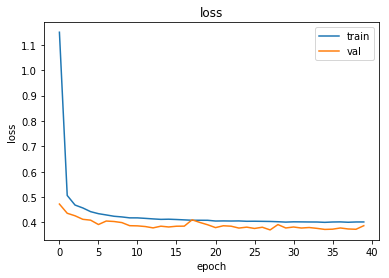

In [0]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

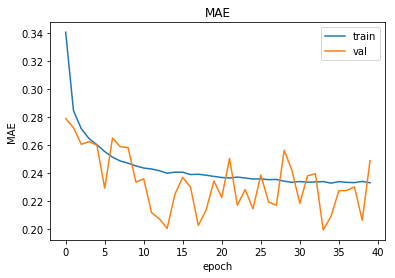

In [0]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

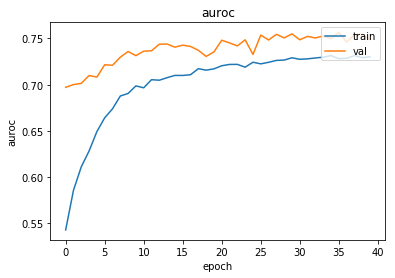

In [0]:
plt.plot(history.history['auroc'])
plt.plot(history.history['val_auroc'])
plt.title('auroc')
plt.ylabel('auroc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

#Feature Extraction

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_train['essay'])

In [0]:
vectorizer.idf_

array([ 7.27351794,  5.88479934, 11.21509975, ..., 11.21509975,
       11.21509975, 10.80963464])

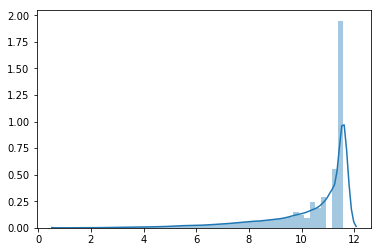

In [0]:
import seaborn as sns
sns.distplot(vectorizer.idf_)

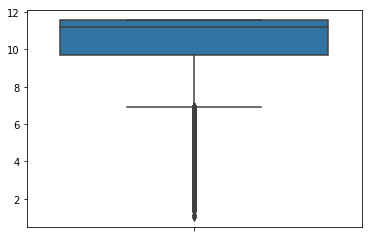

In [0]:
sns.boxplot(x = vectorizer.idf_,orient ='v')

# Choosing words with IDF values between 4 and 11.5

In [0]:
IDF = vectorizer.idf_
dis_Arg = np.append(np.argwhere((IDF < 4)),np.argwhere(IDF > 11.5))
words =np.array(vectorizer.get_feature_names())
dis_words = tuple(words[dis_Arg])
X_train_red  = []
for sent in X_train['essay'].values :
  temp = []
  for word in sent.split():    
    if word not in dis_words :
      temp.append(word)
  X_train_red.append( " ".join(temp))

In [0]:
len(dis_Arg)

25467

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Input,LSTM,Concatenate
from keras.layers import Flatten
from keras.layers import Embedding

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train_red)
Essay_VocabSize_red = len(t.word_index) + 1
# integer encode the documents
encoded_docs_train_red = t.texts_to_sequences(X_train_red)
encoded_docs_test_red = t.texts_to_sequences(X_test['essay'])
encoded_docs_val_red = t.texts_to_sequences(X_CV['essay'])
print(encoded_docs_train_red[0:10])

max_length_essay_red = max([len(a) for a in encoded_docs_train_red])

# create a weight matrix for words in training docs
embedding_matrix_red = zeros((Essay_VocabSize_red, 300),dtype = np.float16)
for word, i in t.word_index.items() :
  if word in model1 :
    embedding_vector_red = model1[word] 
  else :
    embedding_vector_red = zeros(300)
  embedding_matrix_red[i] = embedding_vector_red
print(max_length_essay_red)
padded_docs_train_red = pad_sequences(encoded_docs_train_red, maxlen=max_length_essay_red, padding='post')
padded_docs_test_red = pad_sequences(encoded_docs_test_red, maxlen=max_length_essay_red, padding='post')
padded_docs_val_red = pad_sequences(encoded_docs_val_red, maxlen=max_length_essay_red, padding='post')
print(padded_docs_train_red[0:12])

[[438, 1214, 2594, 2227, 5, 46, 2256, 243, 1922, 13, 1796, 645, 1796, 1624, 4984, 1064, 1222, 9972, 820, 525, 62, 89, 5, 85, 1806, 5, 13, 48, 13, 251, 509, 2535, 3834, 2208, 1464, 847, 251, 509, 3409, 2853], [223, 1119, 461, 2206, 12902, 2443, 687, 10, 511, 1528, 1277, 2206, 154, 262, 262, 2577, 1664, 379, 1716, 235, 1425, 1075, 1784, 2966, 2980, 6745, 171, 925, 2696, 6745, 2327, 1380, 881, 262, 2272, 171, 132, 963, 1328, 255, 3682, 23195, 1380, 2272], [464, 326, 1694, 8406, 4580, 234, 1560, 23196, 5869, 260, 33, 464, 1250, 514, 295, 1046, 801, 2460, 672, 461, 6877, 1178, 4506, 1226, 1644, 784, 693, 1517, 568, 3125, 568, 1995, 377, 2346, 1123, 5372, 333, 13826, 2081, 2421, 520, 390, 568, 568, 594, 771, 7015, 1790, 40, 594, 608, 510, 707, 941, 1517, 721, 281, 390, 721, 32, 1049, 5257, 4624, 954, 756, 334, 1260, 71], [106, 275, 275, 550, 247, 41, 176, 16, 108, 1641, 3482, 9026, 6, 6746, 1513, 856, 2818, 33, 437, 5483, 628, 1137, 2697, 2624, 165, 1831, 321, 484, 3901, 3560, 289], [2222, 6

In [0]:
Essay_VocabSize_red

33545

In [0]:
from tensorboardcolab import *
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://4204deb7.ngrok.io


In [0]:
from keras.layers import Dense,Input,LSTM,concatenate,Dropout
from keras.models import Model
from keras.regularizers import l2

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from time import time

input_shape_1 = Input(shape=(padded_docs_train_red.shape[1],),name = 'essay')
model_1 = Embedding(Essay_VocabSize_red, 300, weights= [embedding_matrix_red],  trainable=False)(input_shape_1)
model_1 = LSTM(80,return_sequences=True,dropout = 0.5,kernel_initializer='random_normal')(model_1)
model_1 = Flatten()(model_1)


input_shape_2 = Input(shape=(1,),name = 'subcategories')
model_2 = Embedding(subcategories_vocab, subcategories_embedding_size)(input_shape_2)
model_2 = Flatten()(model_2)


input_shape_3 = Input(shape=(1,),name = 'categories')
model_3 = Embedding(categories_vocab,categories_embedding_size)(input_shape_3)
model_3 = Flatten()(model_3)

input_shape_4 = Input(shape=(1,),name = 'grade')
model_4 = Embedding(grades_vocab,grades_embedding_size)(input_shape_4)
model_4 = Flatten()(model_4)

input_shape_5 = Input(shape=(1,),name = 'state')
model_5 = Embedding(state_vocab,state_embedding_size)(input_shape_5)
model_5 = Flatten()(model_5)

input_shape_6 = Input(shape= (1,),name = 'teacher')
model_6 = Embedding(teacher_vocab,teacher_embedding_size)(input_shape_6)
model_6 = Flatten()(model_6)

input_shape_7 = Input(shape=(rest_of_columns_train.shape[1],),name = 'rest')
model_7 = Dense(32)(input_shape_7)
                                                                  
merged = concatenate([model_1,model_2,model_3,model_4,model_5,model_6,model_7])
Dense_1 = Dense(80,activation ='relu',kernel_regularizer=l2(0.01),kernel_initializer='he_normal')(merged)
Dense_1 = Dropout(0.8)(Dense_1)                
 
Dense_2 = Dense(64,activation ='relu',kernel_initializer='he_normal')(Dense_1)
Dense_2 = Dropout(0.6)(Dense_2)  
                                                                  
Dense_3 = Dense(32,activation ='relu',kernel_initializer='he_normal')(Dense_2)
Dense_3 = Dropout(0.6)(Dense_3) 
                                                                  
out = Dense(2, activation= 'softmax',name='output_layer')(Dense_3)
model = Model(inputs = [input_shape_1,input_shape_2,input_shape_3,input_shape_4,input_shape_5,input_shape_6,input_shape_7],outputs=[out])
rms = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer= rms, loss='categorical_crossentropy',metrics=['mae', 'acc',auroc])
model.summary()

history = model.fit({
            'essay': np.array(padded_docs_train_red),
            'subcategories': np.array(subcategories_train),
            'categories': np.array(categories_train),
            'grade': np.array(grades_train),
            'state': np.array(state_train),
            'teacher':np.array(teacher_train),
            'rest': np.array(rest_of_columns_train)},
             {'output_layer': y_true}, 
    validation_data=({
            'essay': np.array(padded_docs_val_red),
            'subcategories': np.array(subcategories_val),
            'categories': np.array(categories_val),
            'grade': np.array(grades_val),
            'state': np.array(state_val),
            'teacher':np.array(teacher_val),
            'rest': np.array(rest_of_columns_val)}, {'output_layer': y_val}),
             epochs=30, batch_size=500,callbacks=[TensorBoardColabCallback(tbc)])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay (InputLayer)              (None, 199)          0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 199, 300)     16274400    essay[0][0]                      
__________________________________________________________________________________________________
subcategories (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
categories (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
grade (Inp

In [0]:
results = model.evaluate({
            'essay': np.array(padded_docs_test_red),
            'subcategories': np.array(subcategories_test),
            'categories': np.array(categories_test),
            'grade': np.array(grades_test),
            'state': np.array(state_test),
            'teacher':np.array(teacher_test),
            'rest': np.array(rest_of_columns_test)},
             {'output_layer': y_test} ,batch_size=128)

32775/32775 [==============================] - 40s 1ms/step


In [0]:
print("loss : ",results[0] )
print("Mean absolute Error  : ",results[1] )
print("Accuracy  : ",results[2] )
print("Auroc  : ",results[3] )

loss :  0.46520717229486697
Mean absolute Error  :  0.2067822956429648
Accuracy  :  0.8472311212851017
Auroc  :  0.7207152198131176


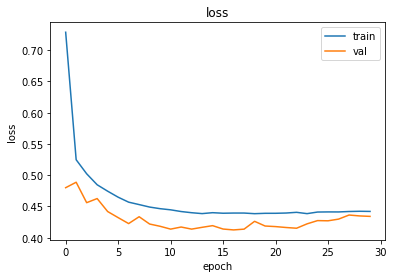

In [0]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

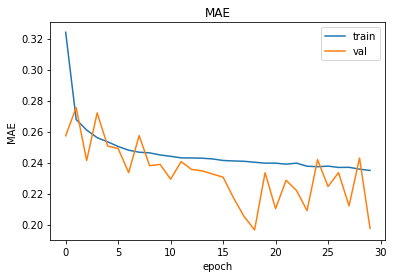

In [0]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

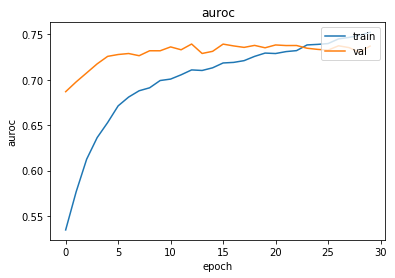

In [0]:
plt.plot(history.history['auroc'])
plt.plot(history.history['val_auroc'])
plt.title('auroc')
plt.ylabel('auroc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [0]:

my_counter = Counter()
for word in X_train['clean_categories'].values:
    my_counter.update(word.split())
cat_dict = dict(my_counter)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary = cat_dict.keys(), lowercase=False, binary=True)
categories_one_hot_train = vectorizer.fit_transform(X_train['clean_categories'].values)
categories_one_hot_test = vectorizer.transform(X_test['clean_categories'].values)
categories_one_hot_cv = vectorizer.transform(X_CV['clean_categories'].values)
print(vectorizer.get_feature_names())

print("Shape of matrix after one hot encodig ",categories_one_hot_test.toarray())

# Categories are properly counted
print(X_train.clean_categories.head(2))
print(X_test.clean_categories.head(2))


# we use count vectorizer to convert the values into one 
my_counter = Counter()
for word in X_train['clean_subcategories'].values:
    my_counter.update(word.split())
subcat_dict = dict(my_counter)
vectorizer = CountVectorizer(vocabulary=list(subcat_dict.keys()), lowercase=False, binary=True)
sub_categories_one_hot_train = vectorizer.fit_transform(X_train['clean_subcategories'].values)
sub_categories_one_hot_test = vectorizer.transform(X_test['clean_subcategories'].values)
sub_categories_one_hot_cv = vectorizer.transform(X_CV['clean_subcategories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encodig ",sub_categories_one_hot_train.shape)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot_train.toarray())

# count vectorize school_state with one
vectorizer = CountVectorizer(vocabulary=list(X_train['school_state'].unique()), lowercase=False, binary=True)
categories_school_state_one_hot_train = vectorizer.fit_transform(X_train['school_state'].values)
print(vectorizer.get_feature_names())
categories_school_state_one_hot_test = vectorizer.transform(X_test['school_state'].values)
categories_school_state_one_hot_cv = vectorizer.transform(X_CV['school_state'].values)
print("Shape of matrix after one hot encodig ",categories_school_state_one_hot_train.toarray())
print("Shape of matrix after one hot encodig ",categories_school_state_one_hot_train.shape)

# count vectorize project_grade_category with one

vectorizer = CountVectorizer(vocabulary=list(X_train['project_grade_category'].unique()),lowercase=False, binary=True)
vectorizer.fit(X_train['project_grade_category'].values)
print(vectorizer.get_feature_names())
categories_project_grade_one_hot_train = vectorizer.transform(X_train['project_grade_category'].values)
categories_project_grade_one_hot_test = vectorizer.transform(X_test['project_grade_category'].values)
categories_project_grade_one_hot_cv = vectorizer.transform(X_CV['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",categories_project_grade_one_hot_train .toarray())
print("Shape of matrix after one hot encodig ",categories_project_grade_one_hot_train .shape)
print("Shape of matrix after one hot encodig ",categories_project_grade_one_hot_test .shape)


# count vectorize teacher_prefix with one
vectorizer = CountVectorizer(vocabulary  = ['Ms', 'Mrs', 'Mr', 'Teacher','Dr'],lowercase=False, binary=True) #Manually assigned vocabulary to fix Na Values
vectorizer.fit(X_train['teacher_prefix'].values)
print(vectorizer.get_feature_names())
categories_teacher_prefix_one_hot_train = vectorizer.transform(X_train['teacher_prefix'].values)
categories_teacher_prefix_one_hot_test = vectorizer.transform(X_test['teacher_prefix'].values)
categories_teacher_prefix_one_hot_cv = vectorizer.transform(X_CV['teacher_prefix'].values)
print("Shape of matrix after one hot encodig ",categories_teacher_prefix_one_hot_train.toarray())
print("Shape of matrix after one hot encodig ",categories_teacher_prefix_one_hot_train.shape)
print("Shape of matrix after one hot encodig ",categories_teacher_prefix_one_hot_test.shape)

from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")
# transforming based on train data
# Now standardize the data with above maen and variance.
price_standardized_train = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
price_standardized_test =  price_scalar.transform(X_test['price'].values.reshape(-1,1))
price_standardized_cv =  price_scalar.transform(X_CV['price'].values.reshape(-1,1))

no_previously_posted_project_scalar = StandardScaler()
no_previously_posted_project_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


# Now standardize the data with above maen and variance.
no_previously_posted_project_standardized_train = no_previously_posted_project_scalar.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
no_previously_posted_project_standardized_test = no_previously_posted_project_scalar.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
no_previously_posted_project_standardized_cv = no_previously_posted_project_scalar.transform(X_CV['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

categories_concat_train = hstack((categories_one_hot_train, sub_categories_one_hot_train,categories_school_state_one_hot_train,categories_project_grade_one_hot_train,categories_teacher_prefix_one_hot_train,price_standardized_train,no_previously_posted_project_standardized_train)).tocsr()
categories_concat_test = hstack((categories_one_hot_test, sub_categories_one_hot_test,categories_school_state_one_hot_test,categories_project_grade_one_hot_test,categories_teacher_prefix_one_hot_test,price_standardized_test,no_previously_posted_project_standardized_test)).tocsr()
categories_concat_cv = hstack((categories_one_hot_cv, sub_categories_one_hot_cv,categories_school_state_one_hot_cv,categories_project_grade_one_hot_cv,categories_teacher_prefix_one_hot_cv,price_standardized_cv,no_previously_posted_project_standardized_cv)).tocsr()


['Literacy_Language', 'Music_Arts', 'Math_Science', 'SpecialNeeds', 'AppliedLearning', 'Health_Sports', 'History_Civics', 'Warmth', 'Care_Hunger']
Shape of matrix after one hot encodig  [[0 0 1 ... 1 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 1 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
81773    Literacy_Language
10725           Music_Arts
Name: clean_categories, dtype: object
72954    History_Civics Math_Science
95557              Literacy_Language
Name: clean_categories, dtype: object
['Literacy', 'VisualArts', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'College_CareerPrep', 'ForeignLanguages', 'Health_Wellness', 'EarlyDevelopment', 'Gym_Fitness', 'ESL', 'Civics_Government', 'CommunityService', 'NutritionEducation', 'Music', 'Warmth', 'Care_Hunger', 'TeamSports', 'Health_LifeScience', 'EnvironmentalScience', 'History_Geography', 'Other', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'Extracurricular', 'FinancialLiteracy', 'Pa

In [0]:
from tensorboardcolab import *
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://88bd2da5.ngrok.io


In [0]:
from keras.layers import Dense,Input,LSTM,concatenate,Conv1D,MaxPooling1D,Concatenate,Activation,Dropout,Flatten

from keras.models import Model
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from time import time
import datetime

input_1 = Input(shape=(padded_docs_train.shape[1],),name = 'essay')
model_1 = Embedding(Essay_VocabSize, 300, weights= [embedding_matrix],  trainable=False)(input_1)
model_1 = LSTM(128,return_sequences=True,dropout = 0.5,kernel_initializer='random_normal')(model_1)
model_1 = Flatten()(model_1)

In [0]:
input_2 = Input(shape=(categories_concat_train.shape[1],1),name = "concat")
model_2 = Conv1D(64,(4,),padding ='same',activation ='relu')(input_2)
model_2 = MaxPooling1D((2,),strides=(1,),padding='same')(model_2)

model_2 = Conv1D(128,(4,),padding ='same',activation ='relu')(model_2)
model_2 = MaxPooling1D((2,),strides=(1,),padding='same')(model_2)
model_2 = Flatten()(model_2)

In [0]:
merged = concatenate([model_1,model_2])
Dense_1 = Dense(128,activation ='relu',kernel_initializer='random_normal',kernel_regularizer=l2(0.01))(merged)
Dense_1 = Dropout(0.6)(Dense_1)                
 
Dense_2 = Dense(64,activation ='relu')(Dense_1)
Dense_2 = Dropout(0.8)(Dense_2)  
                                                                  
Dense_3 = Dense(32,activation ='relu')(Dense_2)                                                                  
out = Dense(2, activation= 'softmax',name='output_layer')(Dense_3)
model_3 = Model(inputs = [input_1,input_2],outputs=[out])
rms = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model_3.compile(optimizer= rms, loss='categorical_crossentropy',metrics=['mae', 'acc',auroc])
model_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
concat (InputLayer)             (None, 101, 1)       0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 101, 64)      320         concat[0][0]                     
__________________________________________________________________________________________________
essay (InputLayer)              (None, 326)          0                                            
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 101, 64)      0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
embedding_

In [0]:
categories_concat_cv.shape

(7648, 101)

In [0]:
categories_concat_train = categories_concat_train.toarray().reshape(68825,101,1)
categories_concat_test  = categories_concat_test.toarray().reshape(32775,101,1)
categories_concat_cv  = categories_concat_cv.toarray().reshape(7648,101,1)

In [0]:
categories_concat_train.shape

(68825, 101)

In [0]:

y_true = to_categorical(Y_train.values, num_classes=2)
y_test = to_categorical(Y_test.values ,num_classes = 2)
history = model_3.fit({
            'essay': np.array(padded_docs_train),
            'concat': np.array(categories_concat_train)},            
             {'output_layer': y_true},
             validation_data=({
            'essay': np.array(padded_docs_cv),
            'concat': np.array(categories_concat_cv)},
             {'output_layer': y_val}),
             epochs=15, batch_size=500,callbacks=[TensorBoardColabCallback(tbc)])

Train on 68825 samples, validate on 7648 samples
Epoch 1/15
68825/68825 [==============================] - 108s 2ms/step - loss: 34.4010 - mean_absolute_error: 0.3585 - acc: 0.7801 - auroc: 0.5143 - val_loss: 0.9993 - val_mean_absolute_error: 0.2989 - val_acc: 0.8584 - val_auroc: 0.6534
Epoch 2/15
68825/68825 [==============================] - 105s 2ms/step - loss: 0.6456 - mean_absolute_error: 0.2567 - acc: 0.8481 - auroc: 0.6165 - val_loss: 0.5624 - val_mean_absolute_error: 0.2471 - val_acc: 0.8584 - val_auroc: 0.7114
Epoch 3/15
68825/68825 [==============================] - 105s 2ms/step - loss: 0.5542 - mean_absolute_error: 0.2484 - acc: 0.8481 - auroc: 0.6731 - val_loss: 0.5266 - val_mean_absolute_error: 0.2492 - val_acc: 0.8584 - val_auroc: 0.7296
Epoch 4/15
68825/68825 [==============================] - 106s 2ms/step - loss: 0.5287 - mean_absolute_error: 0.2452 - acc: 0.8481 - auroc: 0.6940 - val_loss: 0.5240 - val_mean_absolute_error: 0.2861 - val_acc: 0.8584 - val_auroc: 0.748

In [0]:
results = model_3.evaluate({
            'essay': np.array(padded_docs_test),
            'concat': np.array(categories_concat_test)},
             {'output_layer': y_test} ,batch_size=128)

32775/32775 [==============================] - 80s 2ms/step


In [0]:
print("loss : ",results[0] )
print("Mean absolute Error  : ",results[1] )
print("Accuracy  : ",results[2] )
print("Auroc  : ",results[3] )

loss :  0.49440422133031825
Mean absolute Error  :  0.240163068337626
Accuracy  :  0.8472311212851017
Auroc  :  0.7588295754521126


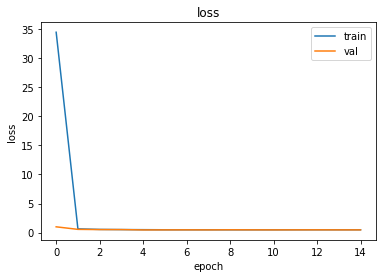

In [0]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

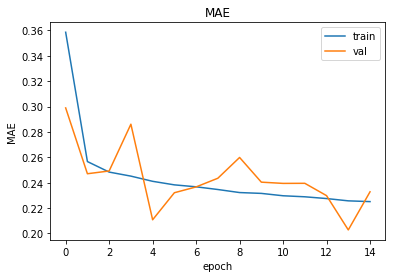

In [0]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

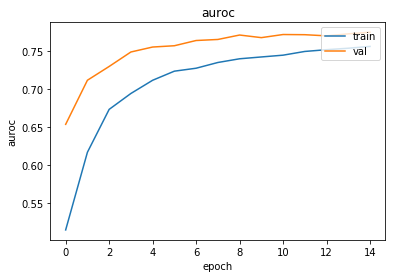

In [0]:
plt.plot(history.history['auroc'])
plt.plot(history.history['val_auroc'])
plt.title('auroc')
plt.ylabel('auroc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [0]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["model", "Loss","MAE","Accuracy", "auroc"]
x.add_row(["model_1",0.4034,0.2558,0.8472,0.7399])
x.add_row(["model_2",0.4652,0.2067, 0.8472, 0.7207])
x.add_row(["model_3",0.4944,0.2401,0.8472, 0.7588])


print(x)

+---------+--------+--------+----------+--------+
|  model  |  Loss  |  MAE   | Accuracy | auroc  |
+---------+--------+--------+----------+--------+
| model_1 | 0.4034 | 0.2558 |  0.8472  | 0.7399 |
| model_2 | 0.4652 | 0.2067 |  0.8472  | 0.7207 |
| model_3 | 0.4944 | 0.2401 |  0.8472  | 0.7588 |
+---------+--------+--------+----------+--------+
